In [19]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier


In [20]:
df = pd.read_csv('../../data/preprocessed_AQI_data.csv')
df.head()

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category,lat,lng
0,130,10126,51,2,1,0,36,0,0,0,51,2,44.7444,44.2031
1,22,10140,41,0,1,0,5,0,1,0,41,0,-5.2900,-44.4900
2,75,10163,66,2,1,0,39,0,2,0,66,2,37.1667,15.1833
3,123,10185,34,0,1,0,34,0,0,0,20,0,53.0167,20.8833
4,166,10243,54,2,1,0,14,0,11,0,54,2,16.1005,-88.8074


In [21]:
from sklearn.model_selection import train_test_split

X = df.drop(["AQI Category"], axis=1)
y = df["AQI Category"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, random_state=22
)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2845, 13) (11384, 13)
(2845,) (11384,)


In [22]:
y.unique()

array([2, 0, 3, 5, 4, 1])

In [23]:
params = {'n_neighbors': [2,3,5,7,9,11],
          'p': [1,2],
          'metric': ['cosine', 'euclidean', 'minkowski']}

In [24]:
clf = KNeighborsClassifier(n_neighbors=3, p=2)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [25]:
clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'uniform'}

In [26]:
# clf.kneighbors()

### Applying grid search

In [27]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)   

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'metric': ['cosine', 'euclidean', 'minkowski'],
                         'n_neighbors': [2, 3, 5, 7, 9, 11], 'p': [1, 2]},
             scoring='accuracy')

In [28]:
print("Best Parameters:", grid_search.best_params_)

# Print the best accuracy score
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'metric': 'cosine', 'n_neighbors': 5, 'p': 1}
Best Accuracy: 0.809841827768014


In [29]:
best_knn = grid_search.best_estimator_
# Evaluate the best model on the test set
test_accuracy = best_knn.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8167603654251581


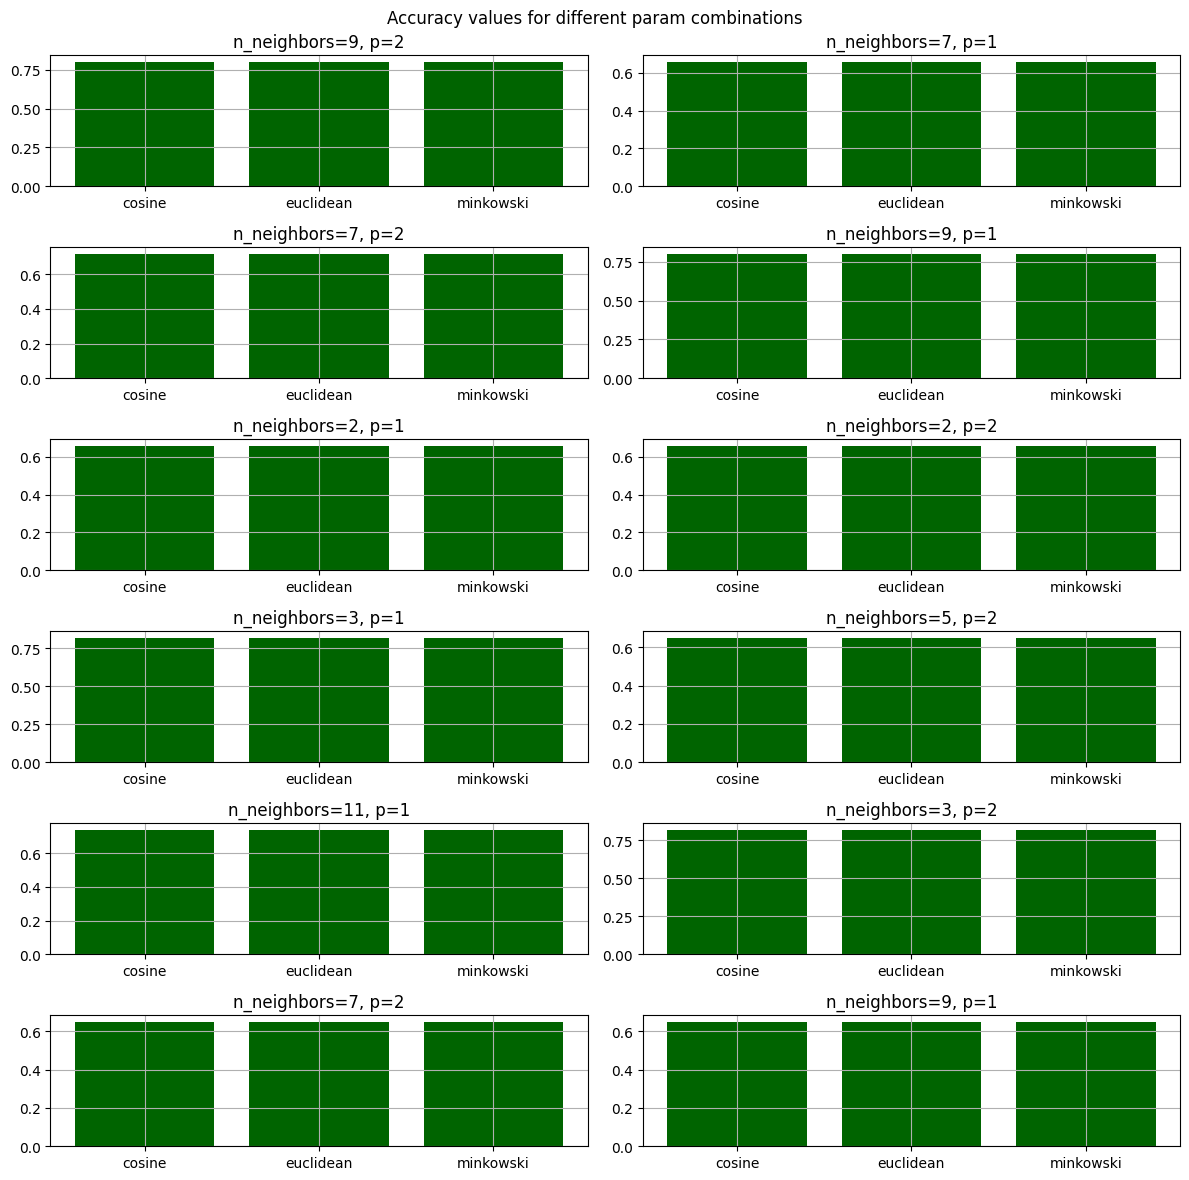

In [30]:
import numpy as np
import matplotlib.pyplot as plt

accuracies = []
param_values = set() 
for n_neighbors in params['n_neighbors']:
    for p in params['p']:
        for metric in params['metric']:
            if (n_neighbors, p, metric) not in param_values:
                knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=p, metric=metric)
                knn.fit(X_train, y_train)
                accuracy = knn.score(X_test, y_test)
                accuracies.append(accuracy)
                param_values.add((n_neighbors, p, metric))

# Create subplots based on unique parameter combinations
fig, axs = plt.subplots(len(params['n_neighbors']), len(params['p']), figsize=(12, 12))
fig.suptitle('Accuracy values for different param combinations')
for i, ax in enumerate(axs.flat):
    n_neighbors, p, metric = list(param_values)[i]
    ax.bar(range(len(params['metric'])), accuracies[i::len(param_values)], color='darkgreen')
    ax.set_xticks(range(len(params['metric'])))
    ax.set_xticklabels(params['metric'])
    ax.set_title(f'n_neighbors={n_neighbors}, p={p}')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [31]:
from sklearn.metrics import classification_report
# rep = classification_report(y)

## Improving the accuracy

In [32]:
# to do : add scaling of the data
# classificatin report

In [33]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()


In [34]:
X_train_rescaled = ss.fit_transform(X_train)
X_test_rescaled = ss.fit_transform(X_test)

In [37]:
clf_ = KNeighborsClassifier(n_neighbors=3, p=2)
clf_.fit(X_train_rescaled, y_train)

KNeighborsClassifier(n_neighbors=3)

In [39]:
y_pred = clf_.predict(X_test_rescaled)

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5332
           1       0.85      0.78      0.81        36
           2       1.00      1.00      1.00      4679
           3       0.88      0.91      0.90       633
           4       0.92      0.95      0.93       604
           5       0.81      0.39      0.53       100

    accuracy                           0.99     11384
   macro avg       0.91      0.84      0.86     11384
weighted avg       0.99      0.99      0.99     11384



In [42]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9862965565706254


In [45]:
rep_ = classification_report(y_pred, y_test)
print(rep_)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5334
           1       0.78      0.85      0.81        33
           2       1.00      1.00      1.00      4685
           3       0.91      0.88      0.90       658
           4       0.95      0.92      0.93       626
           5       0.39      0.81      0.53        48

    accuracy                           0.99     11384
   macro avg       0.84      0.91      0.86     11384
weighted avg       0.99      0.99      0.99     11384

